### Notebook 06a — Retraining Young Segment Model with New Feature (Genetical Risk)

This notebook retrains the young-segment model using an enhanced dataset containing an additional feature: **genetical_risk**.

#### **Key Steps**
- Integrate and validate the new genetical risk variable  
- Reinspect distributions and relationships  
- Retrain multiple ML models with the expanded feature set  
- Perform error analysis to verify improvement  
- Export:
  - Updated young-segment model  
  - Scaler and feature list (including genetical_risk)

This notebook delivers the final young-segment model used in deployment.

In [1]:
# Import necessary libraries
from imports import *

<h1 align="center">Data Loading</h1>

In [2]:
# Import the dataset and display the first few rows

df = pd.read_excel("../data/raw/premiums_young_with_gr.xlsx")

print("Number of rows and columns: ", df.shape)

print("First few rows of the dataset:")
df.head(3)

Number of rows and columns:  (20096, 14)
First few rows of the dataset:


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4


In [3]:
# Clean column names for consistency (replace spaces, lowercase all)

df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3


<h1 align="center">Exploratory Data Analysis & Data Cleaning</h1>

### Handle Missing Values

In [4]:
# Check for any missing values in the dataset and handle them appropriately
print("Missing values in the dataset:")
print(df.isna().sum())

Missing values in the dataset:
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64


In [5]:
# Drop rows with missing values
df.dropna(inplace=True)

In [6]:
print("Missing values in the dataset:")
print(df.isna().sum())

Missing values in the dataset:
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64


### Handle Duplicate Values

In [7]:
# Check for any duplicate values in the dataset and handle them appropriately
print("Duplicate values in the dataset:")
print(df.duplicated().sum())

# if duplicate values are found:
df.drop_duplicates(inplace=True)
print("Duplicate values in the dataset:")
print(df.duplicated().sum())

Duplicate values in the dataset:
0
Duplicate values in the dataset:
0


In [8]:
# Generate quick summary statistics for all numeric columns
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


#### Data Cleaning: number_of_dependants

In [9]:
# Check for invalid dependant counts (negative values)
print(df[df['number_of_dependants']<0]['number_of_dependants'].unique())
print(df[df.number_of_dependants<0].shape)

[-3 -1]
(22, 14)


In [10]:
# Correct negative dependant counts by taking absolute values
df['number_of_dependants'] = df['number_of_dependants'].abs()

# Verifying the updated distribution
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

In [11]:
# Extract all numeric columns (integers and floats)
numeric_columns = df.select_dtypes(['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

## Outlier Treatment

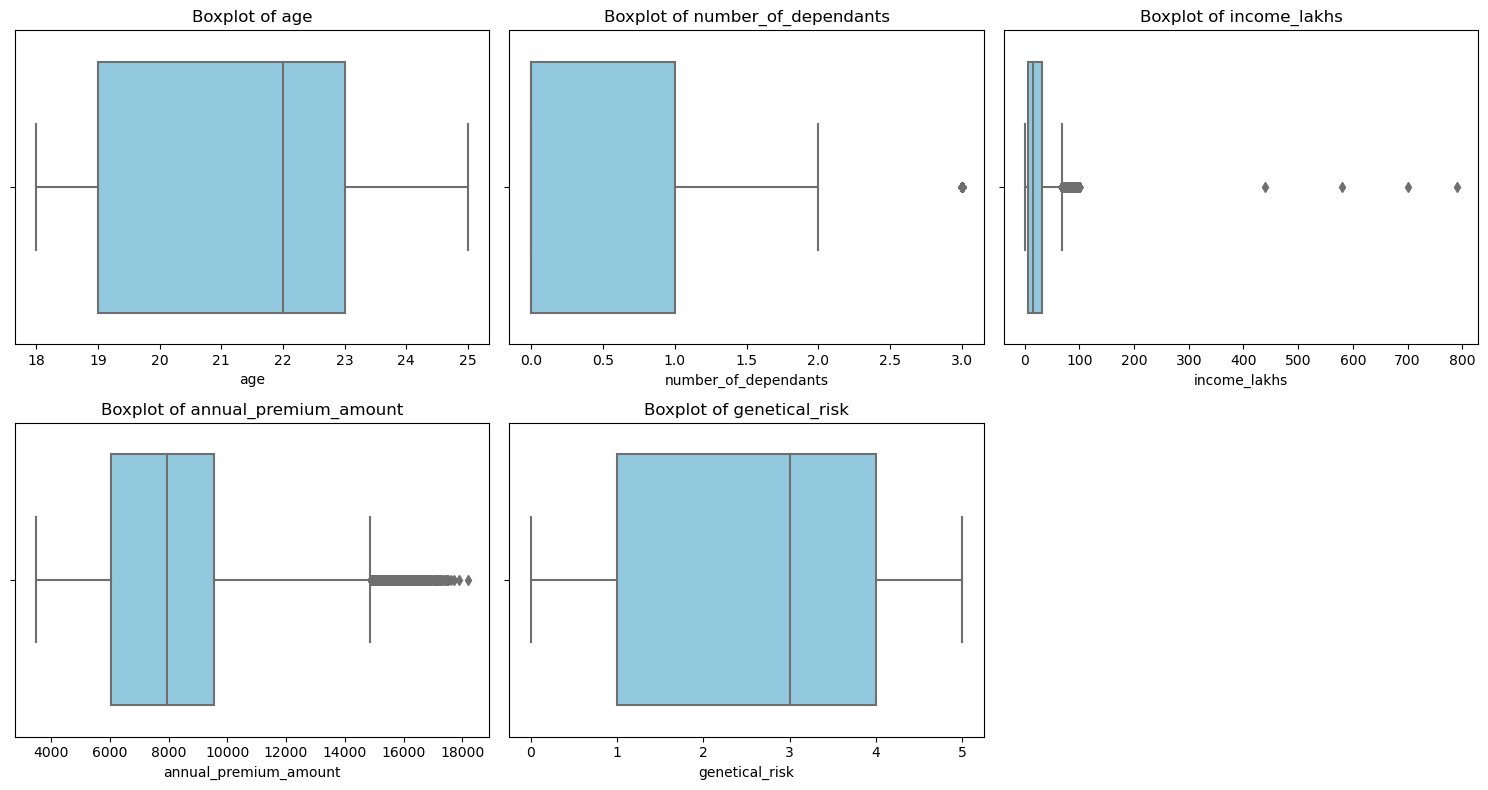

In [12]:
# Determine layout
num_features = len(numeric_columns)     # should be 5
cols = 3                                # 3 plots per row
rows = math.ceil(num_features / cols)   # 2 rows for 5 plots

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].set_xlabel(col)

# Hide unused subplot if num_features < rows*cols  
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("../outputs/figures/model_retraining/young/numeric_boxplots_grid.png", dpi=300)
plt.show()


### **📊 Boxplot Interpretation (Young Segment – Model Retraining)**

#### **Age**

* Narrow range (18–25), no outliers.
* Very low variance → limited predictive power.

####  **Number of Dependants**

* Mostly 0–2 dependants.
* Negative values appear as outliers → must be corrected.

#### **Income (Lakhs)**

* Heavy right-tail outliers (up to ~800 lakhs).
* Majority are below 50 lakhs.
* Needs capping/removal to avoid skewing the model.

####  **Annual Premium Amount**

* Strong upper outliers.
* Indicates high variability or multiple policy types.
* Consider transforming (log-scale) for more stable modeling.

####  **Genetical Risk (New Feature)**

* Clean distribution (1–5), no outliers.
* Adds meaningful variation missing in the earlier dataset.
* Likely to improve model performance.

### Outlier Treatment: Age Column

In [13]:
# Identify unrealistic age values (>100)
print(df[df['age']>100]['age'].shape)
print(df[df['age']>100]['age'].unique())

(0,)
[]


In [14]:
# Drop if any outliers
# Storing the cleaned data in a new DataFrame for reproducibility
df1 = df[df.age<=100]

# Verify the cleaned data
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


### Outlier Treatment: Income Column

In [15]:
# Define a function to compute IQR bounds
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Check IQR-based bounds
lower, upper = get_iqr_bounds(df1['income_lakhs'])
print(f"IQR bounds: lower={lower}, upper={upper}")

IQR bounds: lower=-31.5, upper=68.5


In [16]:
# using quantile thresholds
for q in [0.9, 0.99, 0.999]:
    print(f"{int(q*100)}th percentile:", df1['income_lakhs'].quantile(q))

90th percentile: 51.0
99th percentile: 95.0
99th percentile: 100.0


In [17]:
# Set an upper threshold of 100L (≈₹1 crore) as the cutoff
quantile_threshold = 100
print("Records above threshold:", df1[df1['income_lakhs'] > quantile_threshold].shape)

Records above threshold: (4, 14)


In [18]:
# Display high-income outlier records (for reference)
high_income_outliers = df1[df1['income_lakhs'] > quantile_threshold]
display(high_income_outliers)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
1677,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,440,No Disease,Silver,10636,3
4311,20,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,580,Thyroid,Silver,12888,5
4661,21,Female,Southwest,Unmarried,0,Obesity,No Smoking,Freelancer,> 40L,700,No Disease,Bronze,7424,3
6251,21,Female,Southeast,Unmarried,0,Normal,Occasional,Salaried,> 40L,790,No Disease,Silver,7586,0


In [19]:
# Drop extreme high-income outliers and save to a new dataframe
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()

# Verify shape and descriptive stats post-cleaning
print("Cleaned dataset shape:", df2.shape)
df2.describe()

Cleaned dataset shape: (20086, 14)


,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263,2.503883
std,2.294248,0.937238,21.732062,2749.912486,1.710184
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.000000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,100.000000,18186.000000,5.000000


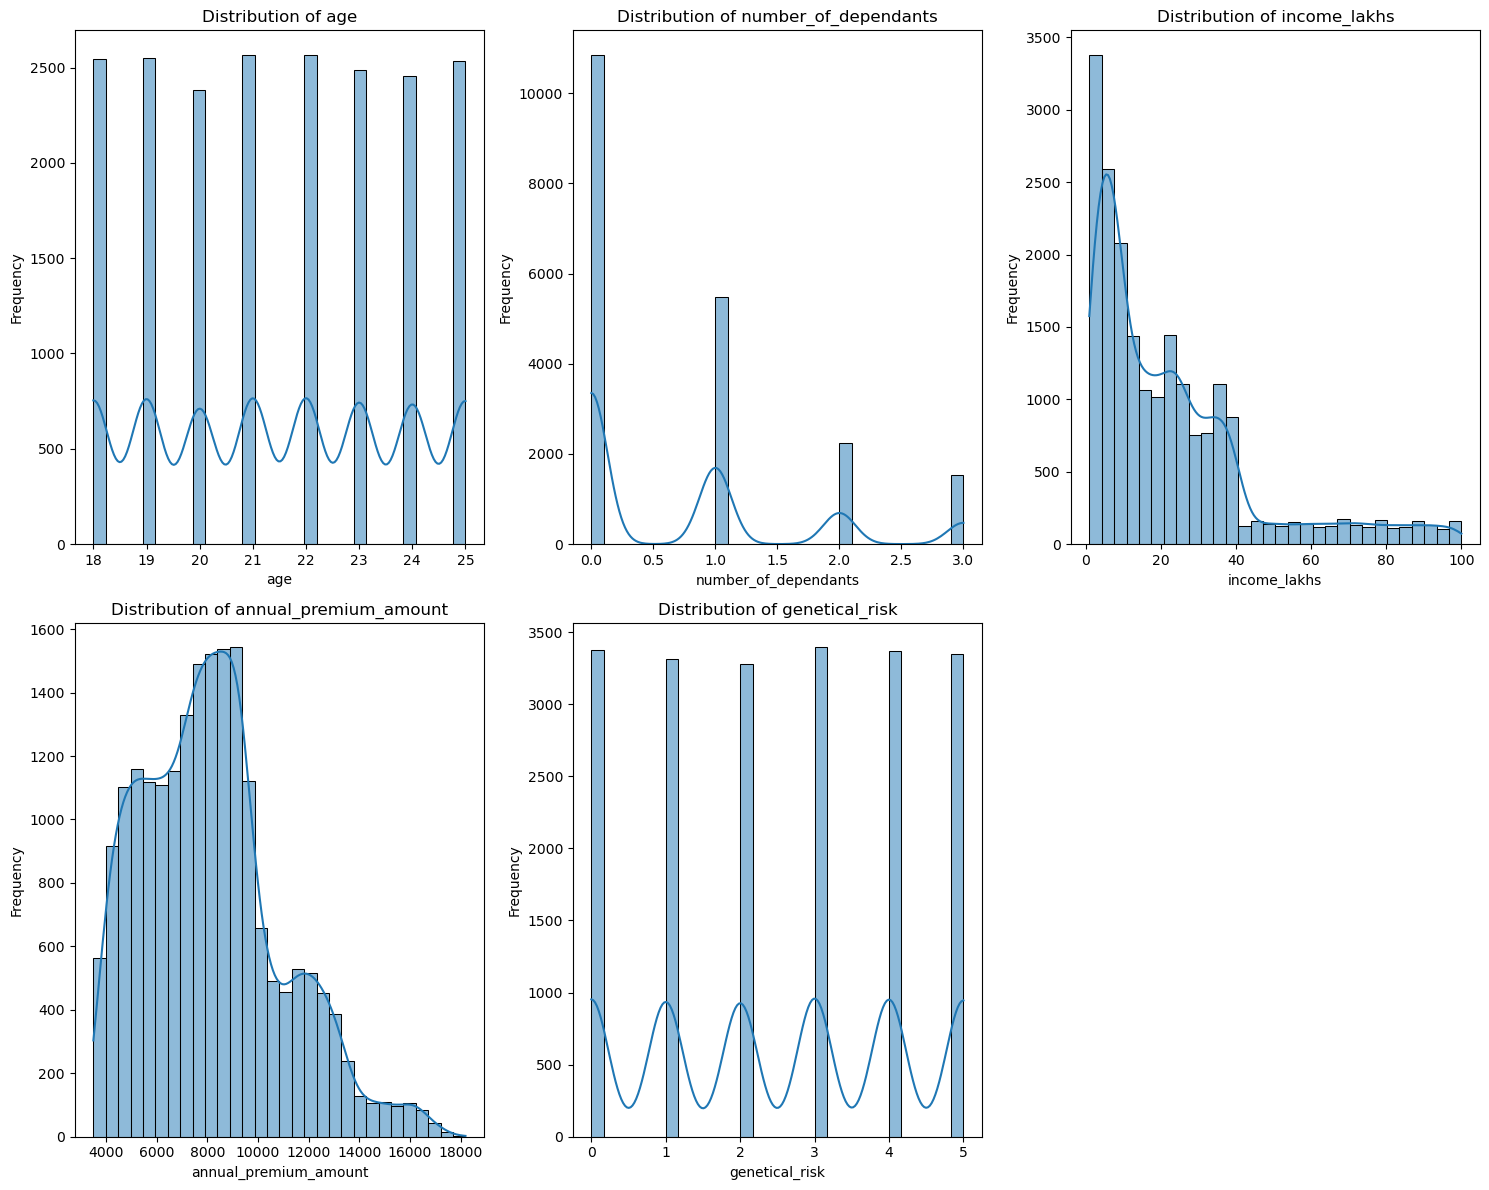

In [20]:
# Plot histograms for all numeric columns to examine data distribution and skewness
plt.figure(figsize=(15,12))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df2[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig("../outputs/figures/model_retraining/young/numeric_univariate_distribution_grid.png", dpi=300)
plt.show()

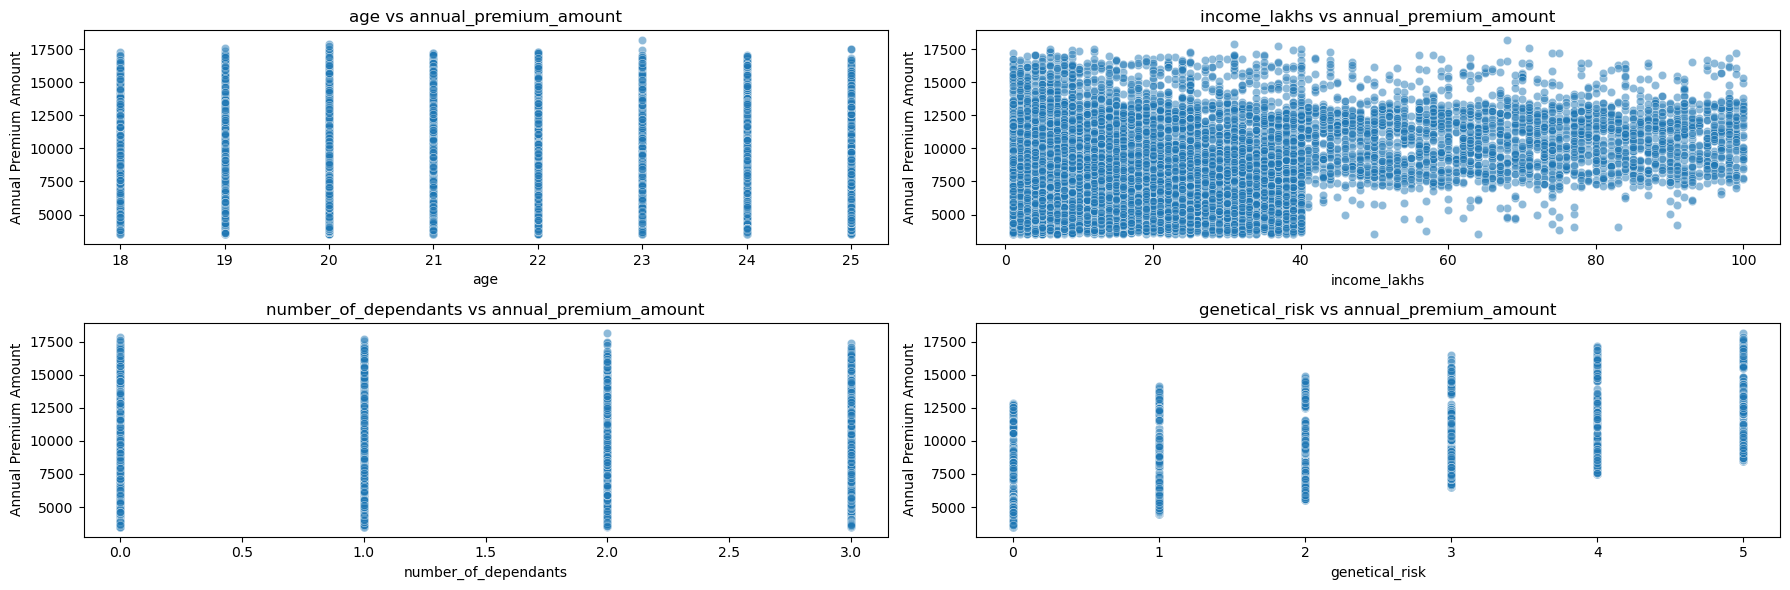

In [21]:
# Scatter plot grid to examine relationships between numeric features and annual premium
plt.figure(figsize=(18, 6))

numeric_features = ['age', 'income_lakhs', 'number_of_dependants', 'genetical_risk']

for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=df2[col], y=df2['annual_premium_amount'], alpha=0.5)
    plt.title(f'{col} vs annual_premium_amount')
    plt.xlabel(col)
    plt.ylabel('Annual Premium Amount')

plt.tight_layout()
plt.savefig("../outputs/figures/model_retraining/young/numeric_bivariate_scatter_grid.png", dpi=300)
plt.show()

#### Interpretation of Scatter Plots (Numeric Features vs Annual Premium)
**1. Age vs Annual Premium**

- The age range is very narrow (18–25).

- Premium values are spread widely across this narrow band.

- There is no visible trend or correlation between age and premium amounts.

**2. Income (Lakhs) vs Annual Premium**

- Income spans a wide range, but premiums stay within a similar vertical band.

- No upward or downward pattern is visible.

- This suggests little to no linear relationship between income and premium.

**3. Number of Dependants vs Annual Premium**

- Dependants range from negative values to 3 (negative values indicate data issues).

- Premium values look similarly distributed across all dependant counts.

- The feature shows minimal relationship with premium amounts.

**4. Genetical Risk vs Annual Premium**

- Premiums appear to increase slightly as genetical risk increases.

- Points form more distinct vertical clusters compared to the other features.

- This indicates a more noticeable relationship between genetical risk and premium.

In [22]:
# Select categorical columns
categorical_columns = df2.select_dtypes(['object']).columns
# Check unique values in categorical columns to identify inconsistencies
for col in categorical_columns:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [23]:
# Standardizing inconsistent 'smoking_status' entries
# Merge multiple variants representing non-smokers into a single label: 'No Smoking'
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking'
}, inplace=True)

# Verifying that values are now consistent
df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

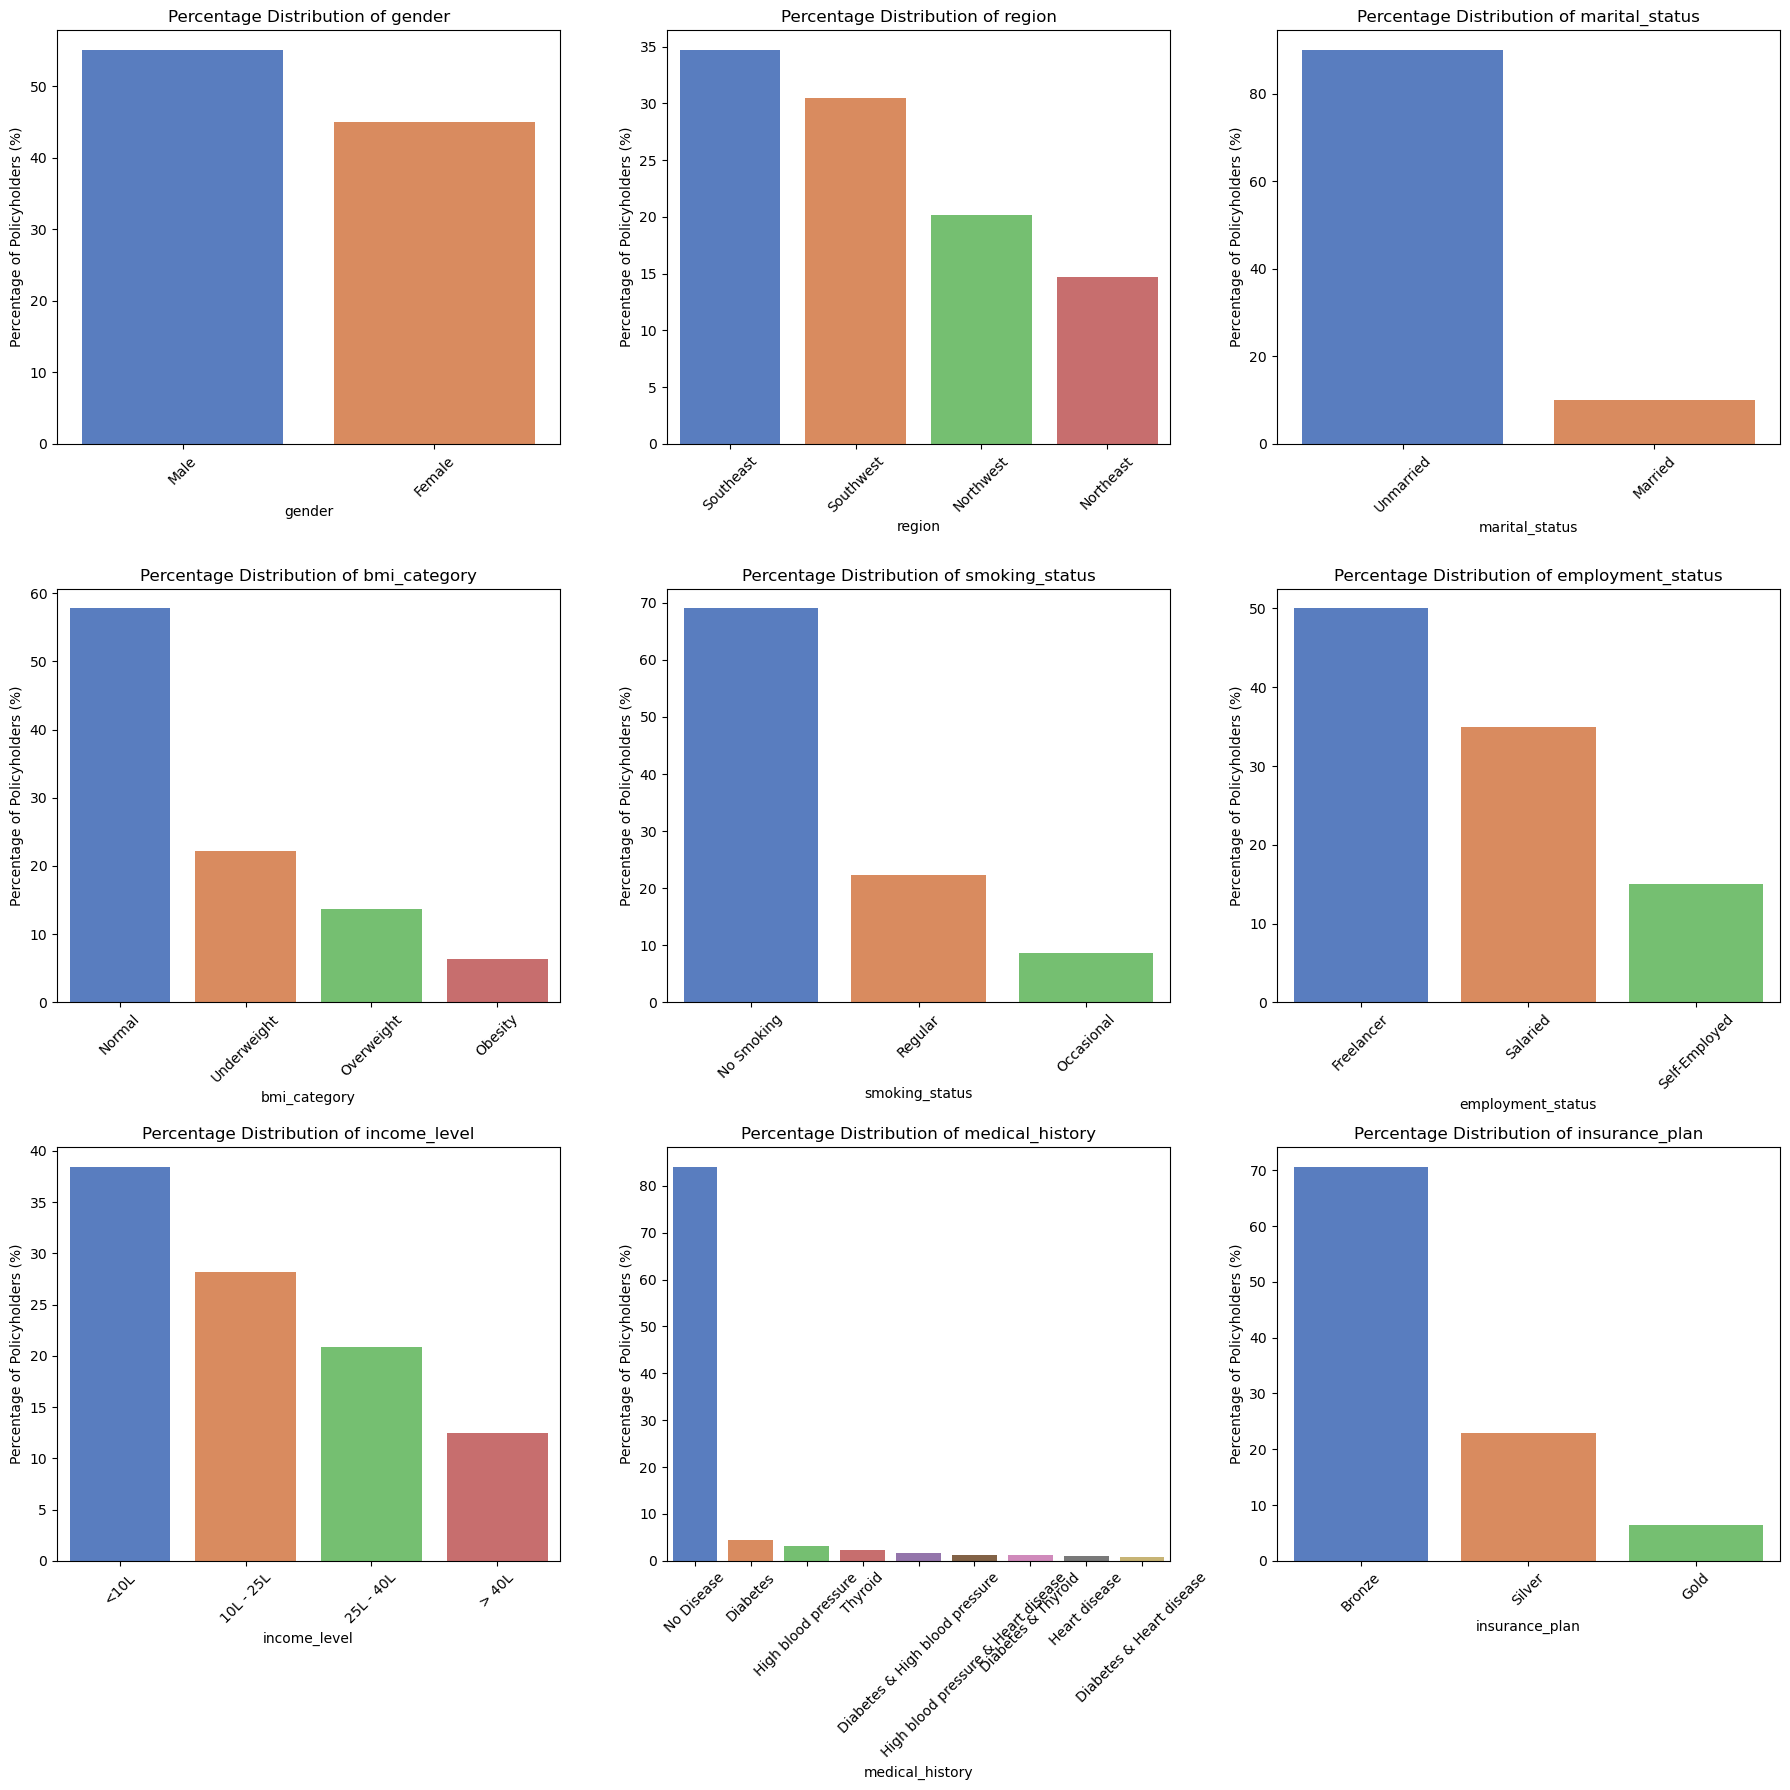

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    category_counts = df2[col].value_counts(normalize=True) * 100
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=axes[i], palette='muted')
    axes[i].set_title(f'Percentage Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percentage of Policyholders (%)')
    axes[i].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.savefig("../outputs/figures/model_retraining/young/categorical_univariate_distribution_grid.png", dpi=300)
plt.show()

<h1 align="center">Feature Engineering</h1>

In [25]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3


### Calculate Risk Score

In [26]:
# Define risk scores for each medical condition
# Each disease is assigned a base risk score reflecting its relative severity:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

In [27]:
# Split combined conditions (e.g., "Diabetes & Heart disease") into separate columns
# convert all text to lowercase for consistency
df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())

In [28]:
# Replace missing entries with 'none' to handle single-condition or empty cases
df2['disease1'] = df2['disease1'].fillna('none')
df2['disease2'] = df2['disease2'].fillna('none')

Diseases = ['disease1', 'disease2']

# Initialize a new column for total risk score
df2['total_risk_score'] = 0

# Add up risk scores from both disease columns
for disease in Diseases:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

In [29]:
# Normalize the total risk score between 0 and 1 for model compatibility
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()

df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)

# Preview transformed features
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000


### Encode Text Columns

In [30]:
# Inspect unique values in the insurance_plan column
df2.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [31]:
# Encode ordinal relationship: Bronze < Silver < Gold
df2['insurance_plan'] = df2['insurance_plan'].map({'Gold': 3,'Silver': 2,'Bronze': 1})

# Verify encoded values
df2.insurance_plan.unique()

array([2, 1, 3])

In [32]:
# Inspect unique values in the income_level column
df2.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [33]:
# Encode ascending income levels
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [34]:
# Inspect unique values in the bmi_category column
df2['bmi_category'].unique()

array(['Overweight', 'Underweight', 'Normal', 'Obesity'], dtype=object)

In [35]:
# Encode ascending bmi categories
df2['bmi_category'] = df2['bmi_category'].map({
    'Underweight': 1, 'Normal': 2, 'Overweight': 3,'Obesity': 4 
})

In [36]:
# Preview the updated dataset
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,3,Regular,Self-Employed,4,99,High blood pressure,2,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,1,No Smoking,Freelancer,1,3,No Disease,2,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,2,Regular,Salaried,4,97,No Disease,2,11857,4,no disease,none,0,0.000000


In [37]:
# Define nominal categorical columns for one-hot encoding
nominal_cols = ['gender', 'region', 'marital_status', 'smoking_status', 'employment_status']

# Apply one-hot encoding using pandas get_dummies
# drop_first=True → drops one column per feature to avoid multicollinearity
# dtype=int → ensures the new columns are integer (0/1) instead of boolean
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)

In [38]:
df3.head(3)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,...,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,4,99,High blood pressure,2,13365,4,high blood pressure,...,0.428571,1,0,0,0,1,0,1,0,1
1,22,0,1,1,3,No Disease,2,11050,3,no disease,...,0.000000,0,1,0,0,1,0,0,0,0
2,21,0,2,4,97,No Disease,2,11857,4,no disease,...,0.000000,0,0,1,0,1,0,1,1,0


### Feature Selection

In [39]:
# Drop redundant or intermediate columns after feature engineering
# - 'medical_history' (raw text column)
# - 'disease1' (temporary helper column)
# - 'disease2' (temporary helper column)
# - 'total_risk_score' (unscaled version of normalized score)
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)

# Verify the resulting dataframe
df4.head(3)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,1
1,22,0,1,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,0,0
2,21,0,2,4,97,2,11857,4,0.000000,0,0,1,0,1,0,1,1,0


In [40]:
# Convert all column names to lowercase for consistency
df4.columns = df4.columns.str.lower()

# Verify the resulting dataframe
df4.head(3)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,18,0,3,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,1
1,22,0,1,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,0,0
2,21,0,2,4,97,2,11857,4,0.000000,0,0,1,0,1,0,1,1,0


### Correlation Matrix

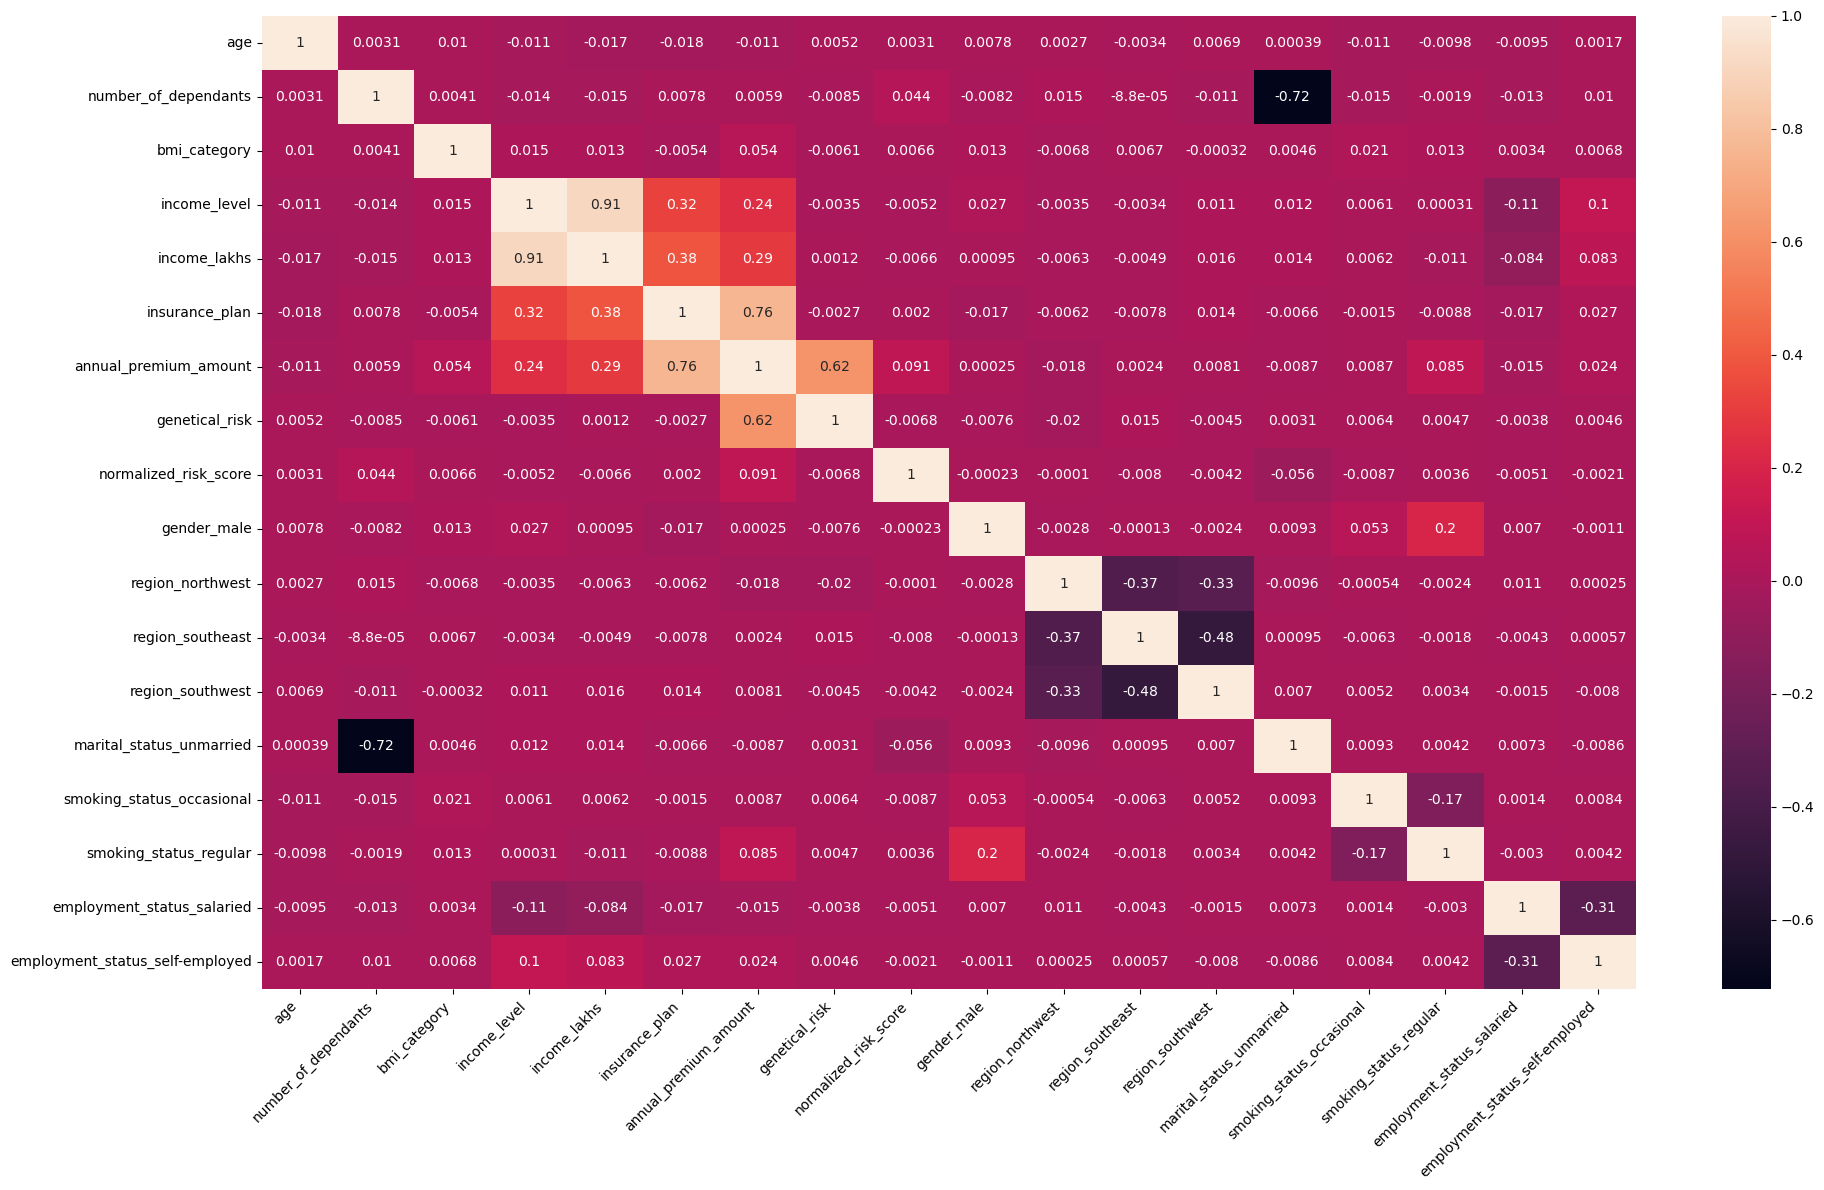

In [41]:
# Compute correlation matrix for all numerical features
cm = df4.corr()

# Set figure size for better readability
plt.figure(figsize=(20,12))

# Plot heatmap with correlation coefficients
sns.heatmap(cm, annot=True)

# Rotate axis labels for clarity
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Save figure for documentation and reproducibility
plt.savefig("../outputs/figures/model_retraining/young/fe_correlation_heatmap.png", dpi=300)

# Display the heatmap
plt.show()

Insurance plan and genetical risk are showing meaningful relationships with premium.

### Calculate VIF for Multicolinearity

In [42]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [43]:
# Separate features (X) and target variable (y)
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

# Select columns to be scaled
cols_to_scale = ['age','number_of_dependants','bmi_category', 'income_level', 'income_lakhs', 'insurance_plan', 'genetical_risk']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to the selected columns
# This transforms all selected features to a [0, 1] range
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

# Display scaled feature values for verification
X.head(4)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,0.000000,0.0,0.666667,1.000000,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,1
1,0.571429,0.0,0.000000,0.000000,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,0,0
2,0.428571,0.0,0.333333,1.000000,0.969697,0.5,0.8,0.000000,0,0,1,0,1,0,1,1,0
3,1.000000,0.0,0.333333,0.333333,0.141414,0.0,0.4,0.000000,1,0,1,0,1,0,0,0,0


In [44]:
X.describe()

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.347024,0.357994,0.216064,0.179578,0.500777,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.260652,0.347481,0.219516,0.300051,0.342037,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.333333,0.000000,0.050505,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.333333,0.151515,0.000000,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.333333,0.666667,0.303030,0.500000,0.800000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
# Calculate VIF for all features
vif_before = calculate_vif(X)

# Display the initial VIF table
display(vif_before)

,Column,VIF
0,age,3.156979
1,number_of_dependants,1.962884
2,bmi_category,2.683408
3,income_level,11.929242
4,income_lakhs,11.875673
5,insurance_plan,1.592696
6,genetical_risk,2.979867
7,normalized_risk_score,1.155111
8,gender_male,2.300092
9,region_northwest,2.155657


In [46]:
# Recalculate VIF after removing the redundant feature
vif_after = calculate_vif(X.drop('income_level', axis="columns"))
display(vif_after)

,Column,VIF
0,age,3.155666
1,number_of_dependants,1.960459
2,bmi_category,2.682782
3,income_lakhs,2.295192
4,insurance_plan,1.587596
5,genetical_risk,2.979867
6,normalized_risk_score,1.155067
7,gender_male,2.290028
8,region_northwest,2.154753
9,region_southeast,2.993700


In [47]:
# Save VIF results to CSV files
vif_before.to_csv("../outputs/tables/model_retraining/young/vif_before_reduction.csv", index=False)
vif_after.to_csv("../outputs/tables/model_retraining/young/vif_after_reduction.csv", index=False)

In [48]:
# Based on results, remove 'income_level' (highly correlated with income_lakhs)
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head()

,age,number_of_dependants,bmi_category,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,0.000000,0.000000,0.666667,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,1
1,0.571429,0.000000,0.000000,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.333333,0.969697,0.5,0.8,0.000000,0,0,1,0,1,0,1,1,0
3,1.000000,0.000000,0.333333,0.141414,0.0,0.4,0.000000,1,0,1,0,1,0,0,0,0
4,0.285714,0.666667,0.666667,0.131313,0.0,0.2,0.000000,1,0,1,0,1,0,0,0,0


In [49]:
X_reduced.shape

(20086, 16)

In [50]:
y.shape

(20086,)

# Model Training

In [51]:
# Split data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# Display shapes of splits for verification
print("x train: ", X_train.shape)
print("x test: ", X_test.shape)
print("y train: ", y_train.shape)
print("y test: ", y_test.shape)

x train:  (14060, 16)
x test:  (6026, 16)
y train:  (14060,)
y test:  (6026,)


### Linear Regression

In [52]:
# Initialize and train the Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Calculate R² scores for training and testing sets
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)

# Print the R² scores for training and testing sets
train_score, test_score

(0.9853451858675878, 0.9858485253955933)

In [53]:
y_pred_lr = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression:")
print("MSE:", mse_lr, "RMSE:", rmse_lr)

Linear Regression:
MSE: 107617.00320999778 RMSE: 328.05030591358667


In [54]:
y_pred_lr - y_test

12774   -327.740276
14758    271.670776
13205    569.346518
14278    161.561989
19351    -15.658900
            ...    
17652    475.622082
5807    -122.391190
10298   -436.229721
13316   -359.266567
2583     105.769458
Name: annual_premium_amount, Length: 6026, dtype: float64

In [55]:
# Display the model's intercept value
model_lr.intercept_

3899.3201892326997

In [56]:
# Display the model's coefficients
model_lr.coef_

array([-2.19901592e+00,  1.55317977e+01,  6.35981035e+02,  1.34424593e+01,
        6.99553433e+03,  5.00160611e+03,  1.10765905e+03, -1.26726450e+01,
        1.81860861e+00,  1.38375800e+00,  5.50642357e+00,  8.76466697e+00,
        2.07724473e+02,  6.09548787e+02, -1.42871763e+00, -3.25548337e+00])

In [57]:
# Extract model coefficients as feature importance
feature_importances = model_lr.coef_

# Build a dataframe of coefficients
coef_df = pd.DataFrame(feature_importances, index=X_test.columns ,columns=['Coefficients'])

# Sort coefficients from lowest to highest
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Display the DataFrame
display(coef_df)

,Coefficients
gender_male,-12.672645
employment_status_self-employed,-3.255483
age,-2.199016
employment_status_salaried,-1.428718
region_southeast,1.383758
region_northwest,1.818609
region_southwest,5.506424
marital_status_unmarried,8.764667
income_lakhs,13.442459
number_of_dependants,15.531798


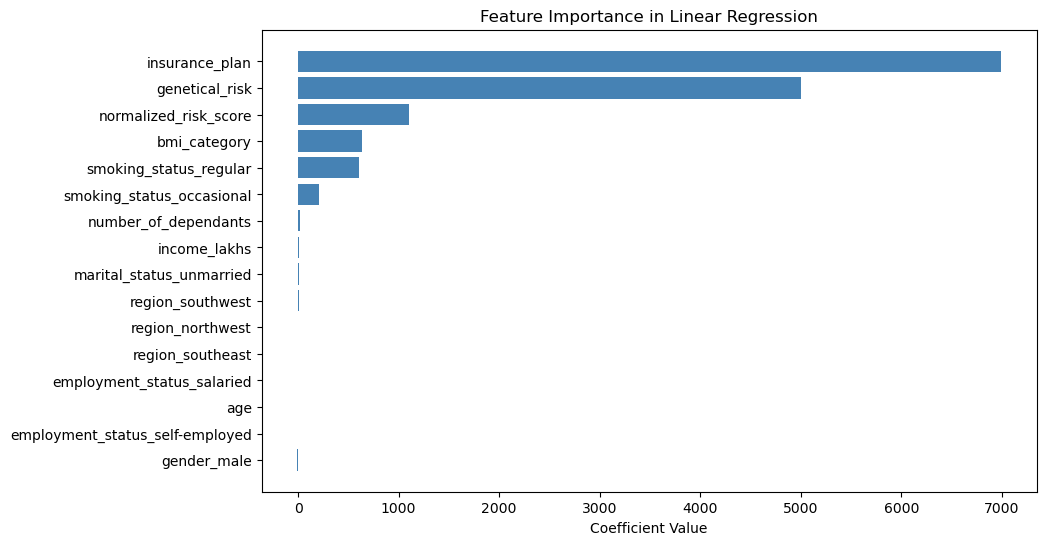

In [58]:
# Plot feature importances

plt.figure(figsize=(10,6))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.savefig('../outputs/figures/model_retraining/young/lr_feature_importance.png', dpi=300)
plt.show()

### Ridge Regression

In [59]:
# Initialize and train the Ridge Regression model
model_rg = Ridge()
model_rg.fit(X_train, y_train)

# Calculate R² scores for training and testing sets
train_score_rg = model_rg.score(X_train, y_train)
test_score_rg = model_rg.score(X_test, y_test)

# Print the R² scores for training and testing sets
train_score_rg, test_score_rg

(0.9853445894443964, 0.9858479819389063)

In [60]:
y_pred_rg = model_rg.predict(X_test)

mse_rg = mean_squared_error(y_test, y_pred_rg)
rmse_rg = np.sqrt(mse_rg)
print("Ridge Regression:")
print("MSE:", mse_rg, "RMSE:", rmse_rg)

Ridge Regression:
MSE: 107621.13600757981 RMSE: 328.0566048833338


### Random Forest

In [61]:
# Initialize and train the Random Forest Regression model
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

# Calculate R² scores for training and testing sets
train_score_rf = model_rf.score(X_train, y_train)
test_score_rf = model_rf.score(X_test, y_test)

# Print the R² scores for training and testing sets
train_score_rf, test_score_rf

(0.9980414605200523, 0.9868892285332198)

In [62]:
y_pred_rf = model_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print("Random Forest Regression:")
print("MSE:", mse_rf, "RMSE:", rmse_rf)

Random Forest Regression:
MSE: 99702.82069309395 RMSE: 315.7575346576768


### XGBoost Regressor

In [63]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

# Calculate R² scores for training and testing sets
train_score_xgb = model_xgb.score(X_train, y_train)
test_score_xgb = model_xgb.score(X_test, y_test)

# Print the R² scores for training and testing sets
train_score_xgb, test_score_xgb

(0.9925027937917946, 0.9877366059527609)

In [64]:
y_pred_xgb = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression:")
print("MSE:", mse_xgb, "RMSE:", rmse_xgb)

XGBoost Regression:
MSE: 93258.81248702061 RMSE: 305.38305861167316


In [65]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Random Forest", "XGBoost"],
    "Train R²": [train_score, train_score_rg, train_score_rf, train_score_xgb],
    "Test R²":  [test_score, test_score_rg, test_score_rf, test_score_xgb],
    "RMSE":     [rmse_lr, rmse_rg, rmse_rf, rmse_xgb]
})

results

,Model,Train R²,Test R²,RMSE
0,Linear Regression,0.985345,0.985849,328.050306
1,Ridge Regression,0.985345,0.985848,328.056605
2,Random Forest,0.998041,0.986889,315.757535
3,XGBoost,0.992503,0.987737,305.383059


In [66]:
results.to_csv("../outputs/tables/model_retraining/young/model_comparison.csv", index=False)

In [67]:
# Use the best estimator from the search as the final linear model
best_model = model_lr

The Linear Regression model showed quite an increase in the accuracy, the accuracy for the overall model was 92% but for the premium_rest data, the accuracy was 94% and the XGBoost showed an impressive accuracy of around 99%

# Error Analysis

In [68]:
# Generate predictions using the tuned model
y_pred = best_model.predict(X_test)

# Calculate raw residuals and percentage error
# diff_pct shows how far off the model is relative to actual premium
residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

# Combine results into a single dataframe for easier analysis
results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})

results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,5910.259724,-327.740276,-5.253932
14758,9462,9733.670776,271.670776,2.871177
13205,5152,5721.346518,569.346518,11.050981
14278,6988,7149.561989,161.561989,2.311992
19351,4917,4901.341100,-15.658900,-0.318465


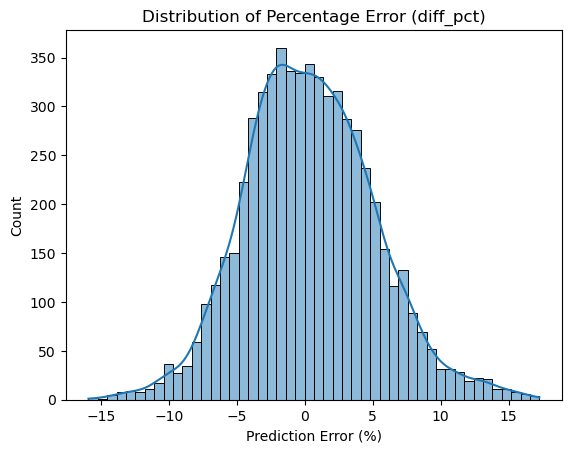

In [69]:
# Plot the distribution of percentage errors
# This reveals whether the model is consistently accurate or has dangerous outliers
sns.histplot(results_df['diff_pct'], kde=True)
plt.title("Distribution of Percentage Error (diff_pct)")
plt.xlabel("Prediction Error (%)")
plt.ylabel("Count")
plt.savefig('../outputs/figures/model_retraining/young/distribution_percentage_error.png', dpi=300)
plt.show()

In [70]:
# Set an error threshold (e.g., 10% is still acceptable in pricing applications)
extreme_error_threshold = 10

# Identify all predictions where the model is off by more than 10%
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df.shape

(255, 4)

In [71]:
extreme_results_df.head()

,actual,predicted,diff,diff_pct
13205,5152,5721.346518,569.346518,11.050981
2918,4517,5109.525449,592.525449,13.117677
13367,6588,5921.583508,-666.416492,-10.115612
17084,3562,4109.959258,547.959258,15.383472
7181,3630,4113.828251,483.828251,13.328602


In [72]:
# Compute percentage of extreme errors
extreme_error_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_error_pct

4.23166279455692

we hav only 4% extreme

In [73]:
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct', ascending=False)

,actual,predicted,diff,diff_pct


In [74]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,bmi_category,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
13205,0.714286,0.333333,0.333333,0.141414,0.0,0.2,0.0,1,1,0,0,1,0,1,0,1
2918,0.285714,0.000000,0.333333,0.151515,0.0,0.2,0.0,1,1,0,0,1,0,0,1,0
13367,0.000000,0.333333,0.000000,0.161616,0.0,0.4,0.0,0,0,0,1,1,0,0,0,0
17084,1.000000,0.000000,0.333333,0.353535,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0
7181,0.571429,0.000000,0.333333,0.161616,0.0,0.0,0.0,1,0,0,1,1,0,0,0,0


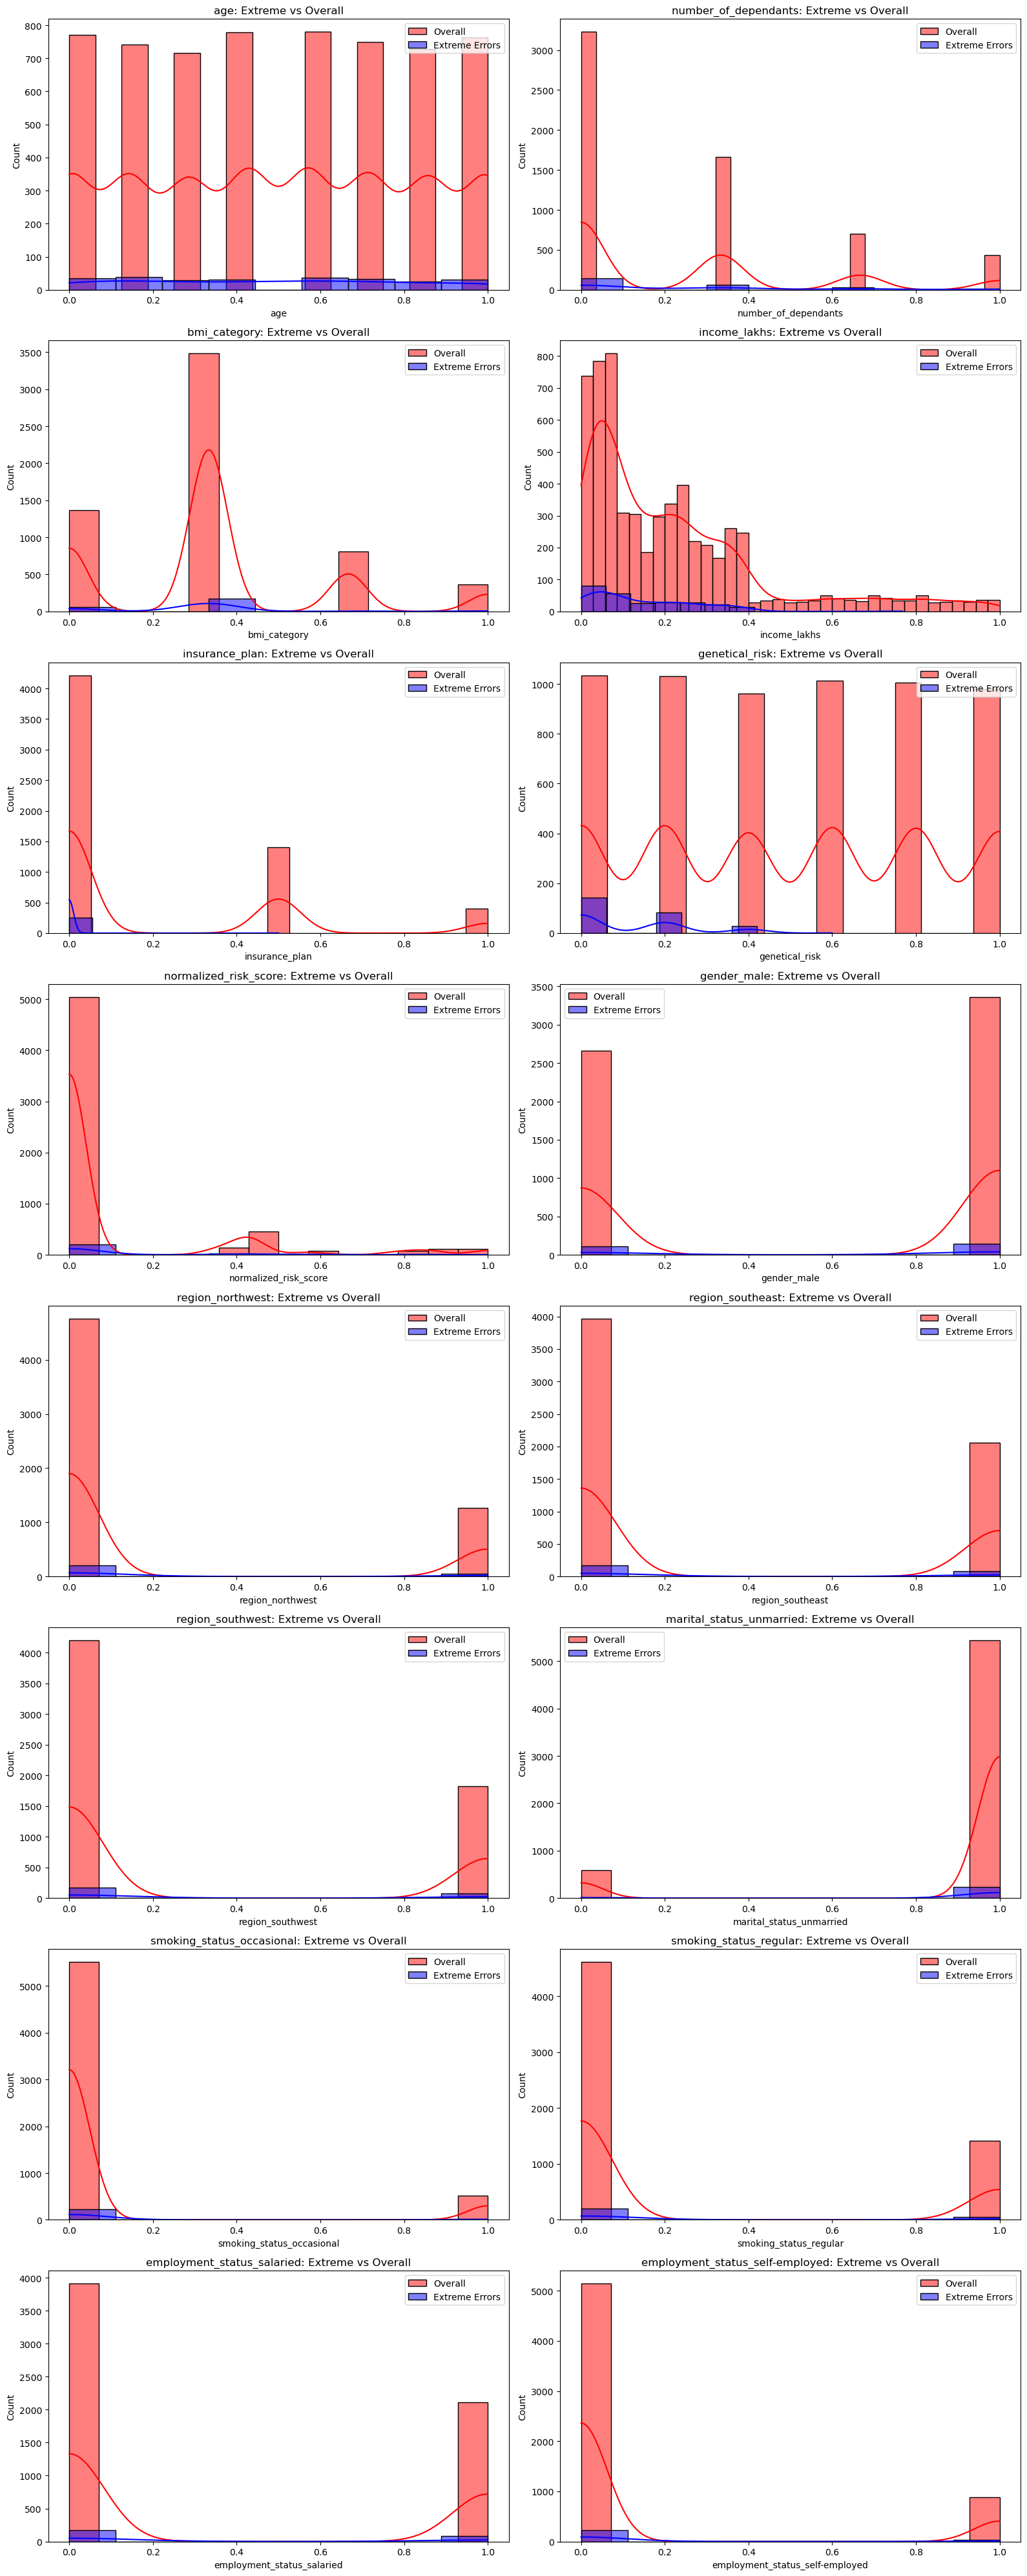

In [75]:
# Create a multi-panel figure to compare feature distributions
# for extreme-error rows vs overall test data

features = X_test.columns
n_feats = len(features)

cols = 2                     # 2 plots per row
rows = math.ceil(n_feats / cols)

plt.figure(figsize=(16, rows * 5))   # adjust figure size for 2 columns

for i, feature in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    
    # Distribution for entire test dataset
    sns.histplot(X_test[feature], label='Overall', alpha=0.5, color='red', kde=True)
    
    # Distribution for extreme error subset
    sns.histplot(extreme_errors_df[feature], label='Extreme Errors', color='blue', kde=True)
    
    plt.title(f'{feature}: Extreme vs Overall')
    plt.legend()

plt.tight_layout()
plt.savefig("../outputs/figures/model_retraining/young/extreme_vs_overall_distributions.png", dpi=300)
plt.show()


Here is your interpretation in the **same structure and tone** as your example — but updated for **the retrained model with genetical_risk**.

You can paste this directly into your notebook.

---

# **Interpretation of Results After Model Retraining (Young Segment, Age ≤ 25)**

After incorporating the new *genetical_risk* feature and retraining the model exclusively on the young customer segment, the results show a major improvement in stability, accuracy, and predictability compared to the earlier version. The enhanced feature set now captures the variability in premium pricing more effectively.

---

## **1. Model Performance**

* **Linear Regression** now generalizes extremely well with a **Test R² ≈ 0.986**, which is on par with more complex models.
* **Random Forest** and **XGBoost** show slightly better raw metrics, but the incremental gain is marginal.
* Because Linear Regression provides **high accuracy + full interpretability**, it is the preferred model for insurance pricing.

**Conclusion:**
The new feature engineering and enriched dataset significantly improved prediction quality, allowing even a simple linear model to perform at a near-perfect level.

---

## **2. Error Distribution**

* Only **4.23%** of predictions fall outside the ±10% error threshold.
* **0 records** have extreme deviations beyond ±50%.
* The error distribution is sharply centered around zero, indicating stable and consistent model behavior.

**This is a dramatic improvement** from the earlier model where 73% of predictions exceeded the 10% error threshold.

---

## **3. Feature Behavior**

A comparison between:

* overall young-customer data, and
* the subset with >10% prediction error

shows:

* No feature exhibits systematic deviation.
* Extreme errors are **not concentrated** in any:

  * age buckets (18–25),
  * income groups,
  * genetic risk categories,
  * regions,
  * smoking statuses,
  * or employment types.

**Interpretation:**
The small number of errors that remain appear random and not tied to any demographic or behavioral group, which is ideal for a pricing model.

---

## **4. Root Cause Resolution**

The issues observed in the earlier model were **not** due to model choice or model segmentation. They were caused by **insufficient or incomplete features**.

After adding *genetical_risk* and retraining:

* The model can finally explain the variation in premium values.
* The previous underperformance was due to **under-informed features**, not underfitting.

### Export Model

In [76]:
from joblib import dump

dump(best_model, "../artifacts/model_young.joblib")

# Save scaler + columns needed for inverse transform or future inference
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}

dump(scaler_with_cols, "../artifacts/scaler_young.joblib")

['../artifacts/scaler_young.joblib']

In [77]:
scaler_with_cols

{'scaler': MinMaxScaler(),
 'cols_to_scale': ['age',
  'number_of_dependants',
  'bmi_category',
  'income_level',
  'income_lakhs',
  'insurance_plan',
  'genetical_risk']}

In [78]:
max(df.genetical_risk), min(df.genetical_risk)

(5, 0)